In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from itertools import groupby
import gc

from torch import tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
def_device

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

np.random.seed(0)
pd.set_option('display.precision', 2)  
pd.set_option('display.float_format', '{:.2f}'.format) 

# Find Train Series

In [2]:
train_events = pd.read_csv("/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv")

In [3]:
series_has_nan = train_events.groupby('series_id')['step'].apply(lambda x: x.isnull().any())
series_clean = series_has_nan[~series_has_nan].index.tolist()
series_clean[:4]

['08db4255286f', '0a96f4993bd7', '0cfc06c129cc', '1087d7b0ff2e']

We are only concerned with boundary data and obtain the first 60 data of each onset or wakeup for training.
test_pred_value[:1]

In [18]:
import torch.multiprocessing as mp
import polars as pl
import functools

# @functools.lru_cache(maxsize=None)
def get_one_series(series):
    """
    The default lru_cache method does not multi processing, The function @lru_cache uses an in memory cache. Each python process contains its own memory block.
    """
    print(f'fetch {series} \n')
    one_series = pd.read_parquet("/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet", filters=[('series_id','=',series)])
    return one_series

def get_multi_light_series(series_ids):
    print(f'fetch {series_ids} \n')
    multi_series = pd.read_parquet("/kaggle/input/zzzs-lightweight-training-dataset-target/Zzzs_train.parquet", filters=[('series_id','in',series_ids)])
    multi_series = multi_series.astype({'series_id':'category','step':'int16','awake': 'int16'})
    multi_series =  add_features(multi_series)
    return multi_series


def get_train_series(series):
    one_series = get_one_series(series)
    one_events = train_events.query('series_id == @series')
    
    one_series.dropna(inplace=True)
    one_events.loc[:, "step"]  = one_events["step"].astype("int")

    train = pd.merge(one_series, one_events[['step','event']], on='step', how='left')
    event_idx = ~train['event'].isna()
    
    before_event_idx = ~train['event'].shift(-12*60*2).isna() # window_size 
    after_event_idx = ~train['event'].shift(12*60*2).isna() # window_size 

    event_windows = []
    for begin, center, end in zip(before_event_idx.index[before_event_idx],event_idx.index[event_idx], after_event_idx.index[after_event_idx]):
        one_window = train[begin:end].copy()
        last_evt = one_window['event'][center]
        one_window.loc[begin:center, 'event'] = 'awake' if last_evt == 'onset' else 'sleep' 
        one_window.loc[center:end, 'event'] = 'sleep' if last_evt == 'onset' else 'awake' 
        event_windows.append(one_window)

    event_windows = pd.concat(event_windows)
    event_windows =  add_features(event_windows)
    del one_series
    gc.collect()
    return event_windows

def add_features(df):
    df["timestamp"] = pd.to_datetime(df["timestamp"],utc=True)
    df["hour"] = df["timestamp"].dt.hour
    df["dayofweek"] = df["timestamp"].dt.dayofweek

    df["anglez_times_enmo"] = abs(df["anglez"]) * df["enmo"]

    periods = 6 # 1/2 minute
    df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).fillna(method="bfill")
    df["enmo_diff"]   = df.groupby('series_id')['enmo'].diff(periods=periods).fillna(method="bfill")
    
    df["anglez_mean"] = df["anglez"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float32')
    df["enmo_mean"]   = df["enmo"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float32')
    
    df["anglez_min"] = df["anglez"].rolling(periods,center=True).min().fillna(method="bfill").fillna(method="ffill")
    df["enmo_min"]   = df["enmo"].rolling(periods,center=True).min().fillna(method="bfill").fillna(method="ffill")
    
    df["anglez_max"] = df["anglez"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill")
    df["enmo_max"]   = df["enmo"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill")
    
    df["anglez_std"] = df["anglez"].rolling(periods,center=True).std().fillna(method="bfill").fillna(method="ffill")
    df["enmo_std"]   = df["enmo"].rolling(periods,center=True).std().fillna(method="bfill").fillna(method="ffill")
    
    df["anglez_diff_rolling"] = df["anglez_diff"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill")
    df["enmo_diff_rolling"]   = df["enmo_diff"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill")

    return df

# Fetching series using multiple Threads
def get_multi_series(series_ids, n_workers=1, light=True):
    if light:
        multi_series = get_multi_light_series(series_ids)
        multi_series = add_features(multi_series)
        return multi_series
    n_workers = min(n_workers, len(series_ids)) # Sometimes series_ids length are smaller than n_workers
    if len(series_ids) == 1:
        return get_train_series(series_ids[0])
    print(f'start {n_workers} threads')
    with mp.Pool(n_workers) as ex:
        train_all = ex.map(get_train_series, series_ids)
    return pd.concat(train_all)

In [19]:
%time train_all = get_multi_light_series(series_clean[:2])
# %time train_all = get_multi_series(series_clean[:2])
print(f'memory usage: {train_all.memory_usage().sum() / 1024**2: .2f} MB')

fetch ['08db4255286f', '0a96f4993bd7'] 

CPU times: user 2.4 s, sys: 1.88 s, total: 4.28 s
Wall time: 2.39 s
memory usage:  13.96 MB


# Prepare Data

The most memory-consuming operations

In [17]:
train_all.dtypes

series_id                           object
step                                uint32
timestamp              datetime64[ns, UTC]
anglez                             float32
enmo                               float32
event                               object
hour                                 int32
anglez_times_enmo                  float32
anglez_diff                        float32
enmo_diff                          float32
anglez_mean                        float32
enmo_mean                          float32
anglez_min                         float64
enmo_min                           float64
anglez_max                         float64
enmo_max                           float64
anglez_std                         float64
enmo_std                           float64
anglez_diff_rolling                float64
enmo_diff_rolling                  float64
dtype: object

In [16]:
train_all.head()

,series_id,step,timestamp,anglez,enmo,event,hour,anglez_times_enmo,anglez_diff,enmo_diff,anglez_mean,enmo_mean,anglez_min,enmo_min,anglez_max,enmo_max,anglez_std,enmo_std,anglez_diff_rolling,enmo_diff_rolling
10548,08db4255286f,10548,2018-11-06 04:39:00+00:00,71.09,0.01,awake,1,0.65,-0.00,0.00,71.09,0.01,71.07,0.01,71.11,0.01,0.02,0.00,-0.00,0.00
10549,08db4255286f,10549,2018-11-06 04:39:05+00:00,71.11,0.01,awake,1,0.66,-0.00,0.00,71.09,0.01,71.07,0.01,71.11,0.01,0.02,0.00,-0.00,0.00
10550,08db4255286f,10550,2018-11-06 04:39:10+00:00,71.07,0.01,awake,1,0.64,-0.00,0.00,71.09,0.01,71.07,0.01,71.11,0.01,0.02,0.00,-0.00,0.00
10551,08db4255286f,10551,2018-11-06 04:39:15+00:00,71.11,0.01,awake,1,0.67,-0.00,0.00,71.09,0.01,71.07,0.01,71.11,0.01,0.02,0.00,-0.00,0.00
10552,08db4255286f,10552,2018-11-06 04:39:20+00:00,71.11,0.01,awake,1,0.65,-0.00,0.00,71.09,0.01,71.07,0.01,71.11,0.01,0.02,0.00,-0.00,0.00


In [8]:
features = ["hour","anglez_times_enmo",
            "anglez","anglez_diff","anglez_mean","anglez_min","anglez_max","anglez_std","anglez_diff_rolling",
            "enmo","enmo_diff","enmo_mean","enmo_min","enmo_max","enmo_std","enmo_diff_rolling"]

target = 'awake'

scaler = StandardScaler()
# labeled = LabelEncoder()

df_train_X_scaled = scaler.fit_transform(train_all[features])
# df_train_y_values = labeled.fit_transform(train_all[feature_y])

n_past = 12 * 2 # 2 minute
trainX = []
trainY = []

for i in range(n_past, len(df_train_X_scaled)):
    trainX.append(df_train_X_scaled[i - n_past:i, 0:df_train_X_scaled.shape[1]])
    trainY.append(train_all[feature_y][i])
    
trainX, trainY = np.array(trainX), np.array(trainY)

del train_all, df_train_X_scaled
gc.collect()

trainX.shape, trainY.shape

((2844876, 24, 7), (2844876,))

Split Data

In [11]:
split_index = int(len(trainX) * 0.8)

X_train = trainX[:split_index]
X_val = trainX[split_index:]

y_train = trainY[:split_index]
y_val = trainY[split_index:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2275900, 24, 7), (2275900,), (568976, 24, 7), (568976,))

## Create DataLoader

In [12]:
X_train = tensor(X_train, dtype=torch.float32)
y_train = tensor(y_train, dtype=torch.long)

X_val = tensor(X_val, dtype=torch.float32)
y_val = tensor(y_val, dtype=torch.long)

X_train.shape, X_val.shape, y_train.shape, y_val.shape,X_train.dtype, y_train.dtype

(torch.Size([2275900, 24, 7]),
 torch.Size([568976, 24, 7]),
 torch.Size([2275900]),
 torch.Size([568976]),
 torch.float32,
 torch.int64)

The second memory-consuming operation

In [13]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_ds, val_ds = TimeSeriesDataset(X_train,y_train), TimeSeriesDataset(X_val, y_val)
batch_size = 12*60 # 1 hour

train_dl, val_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True), DataLoader(val_ds, batch_size=batch_size, shuffle=False)

# Define LSTM Model

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(def_device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(def_device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(self.relu(out[:, -1, :])) 
        return out

In [15]:
input_size = len(features)
hidden_size = 32 # like 1 2 4 32 64
num_layers = 2
output_size = 2

model = LSTM(input_size, hidden_size, num_layers, output_size)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = F.cross_entropy

model.to(def_device)
model

LSTM(
  (lstm): LSTM(7, 32, num_layers=2, batch_first=True)
  (relu): ReLU()
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

# Train

In [16]:
def accuracy(out, yb): 
    return (out.argmax(axis=1) == yb).float().mean() # Evaluate the accuracy of the model.

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train(True)
        for xb, yb in train_dl:
            xb, yb = xb.to(def_device), yb.to(def_device)
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc, count = 0., 0.,0
            for xb,yb in valid_dl:
                xb, yb = xb.to(def_device), yb.to(def_device)
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred, yb).item()*n
                tot_acc += accuracy(pred, yb).item()*n
        print(f'epoch:{epoch}, loss: {tot_loss/count:.2f}, accuracy: {tot_acc/count:.2f}')
    return tot_loss/count, tot_acc/count

def predict(x):
    with torch.no_grad():
        predicted = model(x).to('cpu')
    return F.log_softmax(predicted, -1).exp()

In [17]:
%time loss,acc = fit(1, model, loss_func, opt, train_dl, val_dl)

epoch:0, loss: 0.13, accuracy: 0.96
CPU times: user 7min 52s, sys: 2min 8s, total: 10min
Wall time: 5min 2s


In [18]:
for _, batch in enumerate(train_dl):
    xb, yb = batch[0].to(def_device), batch[1].to(def_device)
    print(xb.shape, yb.shape)
    break

torch.Size([720, 24, 7]) torch.Size([720])


accuracy: 0.9319444298744202


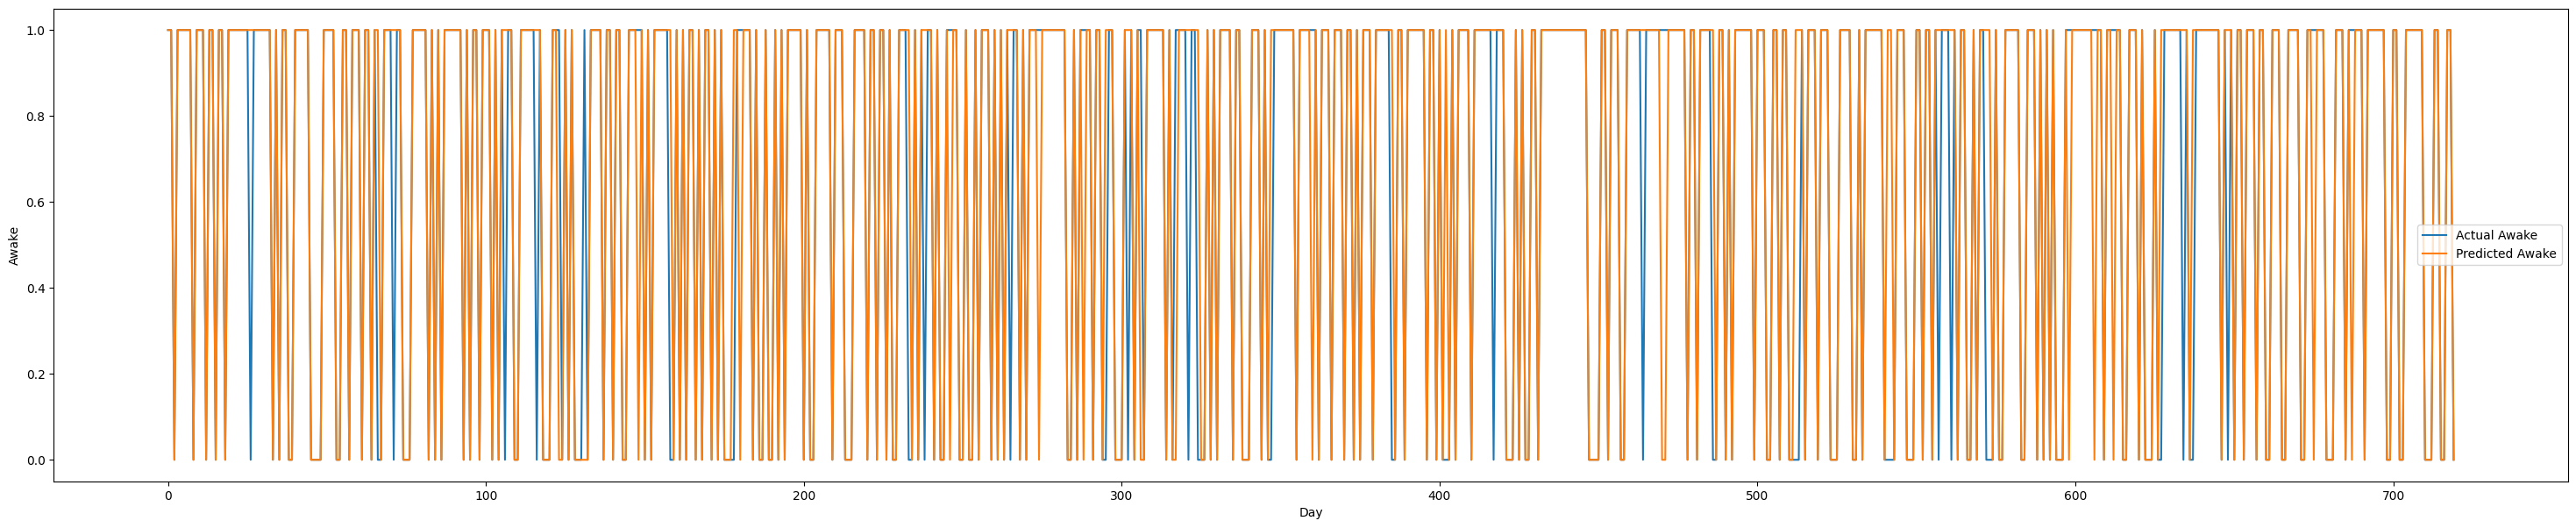

In [19]:
pred = predict(xb)

yb = yb.to('cpu')

print(f'accuracy: {accuracy(pred, yb)}')

pred_value = pred.argmax(axis=1)
act_value = yb

plt.figure(figsize=(37,7))
plt.plot(pred_value, label='Actual Awake')
plt.plot(act_value, label='Predicted Awake')
plt.xlabel('Day')
plt.ylabel('Awake')
plt.legend()
plt.show()

# Predict

In [20]:
import polars as pl
test = (pl.scan_parquet("/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet")
          .collect()
          .to_pandas()
)
test = add_features(test)

In [21]:
test.head()

,series_id,step,timestamp,anglez,enmo,anglez_times_enmo,anglez_diff,enmo_diff,anglez_mean,enmo_mean
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.64,0.02,0.06,0.00,0.00,2.64,0.02
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.64,0.02,0.06,0.00,0.00,2.64,0.02
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.64,0.02,0.06,0.00,0.00,2.64,0.02
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.64,0.02,0.06,0.00,0.00,2.64,0.02
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.64,0.02,0.06,0.00,0.00,2.64,0.02


In [23]:
def data_transform(df):
    df_scaler = scaler.transform(df[features])
    n_past = 12*2 # 2 minute
    testX = []
    for i in range(n_past, len(df_scaler)):
        testX.append(df_scaler[i - n_past:i, 0:df_scaler.shape[1]])
    return tensor(np.array(testX), dtype=torch.float32)
test_tsf = data_transform(test)

In [24]:
test_pred_value = predict(test_tsf.to(def_device))
test_pred_value.shape

torch.Size([426, 2])

In [25]:
test_p = test.iloc[n_past:,].copy() # remove first n_past rows
test_p['score'] = test_pred_value[:,:1]

test_p["not_awake"] = 1-test_p["score"]
smoothing_length = 12
test_p["smooth"] = test_p["not_awake"].rolling(smoothing_length,center=True).mean().fillna(method="bfill").fillna(method="ffill")
test_p["smooth"] = test_p["smooth"].round()

<Figure size 3700x1500 with 0 Axes>

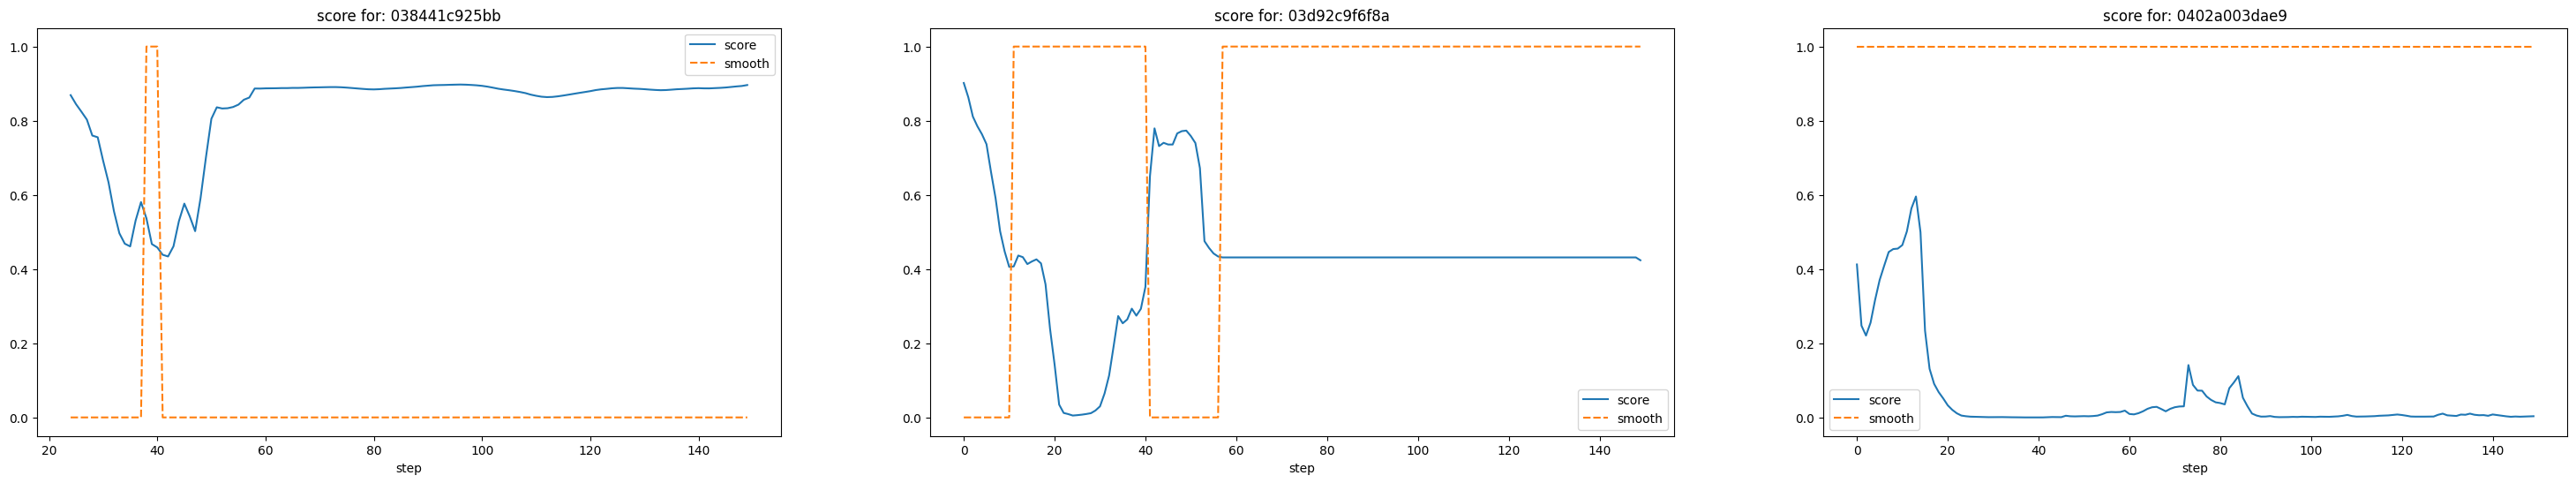

In [26]:
import seaborn as sns

plt.figure(figsize=(37, 15))
fig, axs = plt.subplots(1, 3, figsize=(37, 6))
for series_id,ax in zip(test_p['series_id'].unique().tolist(), axs):
    plot_data = test_p.loc[test_p['series_id'] == series_id, ['step','score','smooth']].copy().set_index('step')
    sns.lineplot(plot_data,  ax=ax)
    ax.set_title(f'score for: {series_id}')
plt.show()

In [27]:
def get_event(df):
    lstCV = zip(df.series_id, df.smooth)
    lstPOI = []
    for (c, v), g in groupby(lstCV, lambda cv: (cv[0], cv[1] != 0 and not pd.isnull(cv[1]))):
        llg = sum(1 for item in g)
        print(c,v,llg)
        if v is False:
            lstPOI.extend([0] * llg)
        else:
            lstPOI.extend(['onset'] + (llg - 2) * [0] + ['wakeup'] if llg > 1 else [0])
    return lstPOI

test_p["event"] = get_event(test_p)

038441c925bb False 14
038441c925bb True 3
038441c925bb False 109
03d92c9f6f8a False 11
03d92c9f6f8a True 30
03d92c9f6f8a False 16
03d92c9f6f8a True 93
0402a003dae9 True 150


In [28]:
sample_submission = test_p.loc[test_p["event"] != 0]
sample_submission.loc[:, 'score'] = 0.9
sample_submission = sample_submission[["series_id", "step", "event", "score"]].copy()
sample_submission = sample_submission.reset_index(drop=True).reset_index(names="row_id")

sample_submission.head()

,row_id,series_id,step,event,score
0,0,038441c925bb,38,onset,0.90
1,1,038441c925bb,40,wakeup,0.90
2,2,03d92c9f6f8a,11,onset,0.90
3,3,03d92c9f6f8a,40,wakeup,0.90
4,4,03d92c9f6f8a,57,onset,0.90


In [ ]:
sample_submission.to_csv('submission.csv', index=False)